# Introduction to Natural Language Processing

**Garren Gaut with contributions from Avishek Kumar**

---


# Table of Contents
 - [Data Source](#Data-Source:-Reddit-Comments-from-May-2015-in-JSON-format)
 - [Preprocess](#Preprocess-the-data)
 - [Supervised Learning](#Comment-Classification:-Supervised-Learning)
 - [Unsupervised Learning](#Comment-Similarity-and-Clustering:-Unsupervised-Learning)
 - [Dimensionality Reduction](#Topic-Modeling:-Dimensionality-Reduction )
 
---

# Introduction


Text Analysis is used for summarizing or extracting useful information from large amounts of  unstructured text. Text analysis encompases a large array of tasks: 

<img src="figs/nlp_tasks.png">

---


 ## Demos 

 - [Stanford NLP](http://nlp.stanford.edu:8080/corenlp/process)    
 - [Illinois Cognitive Computation Group](http://cogcomp.cs.illinois.edu/page/demos/)    
 - [Event Search](http://eventregistry.org/searchEvents)    
 
 ---


## Why is Language Analysis Hard?

- Ambiguity of Language
- Commonsense knowledge is typically omitted from social communications
- Abduction
- Language is dynamic 
- Symbol grounding

## How do we represent a word? 

### One-hot Encoding

`[0,0,0,...,0,1,0,...,0]`

### Distributed Representation 

`[0.34, 0.51,...,0.49, 0.56, 0.72]`

<!-- LSA, word embeddings, vector space embedding --> 


## How do we represent a document? 

### Bag-of-words 

A bag of words is created by summing the one-hot encodings for all words in a document.     


<img src="figs/scrabble-2133.jpg" style="width: 50%; height: 50%"/>


### Document Embedding 

Document embeddings can be created by averaging over word embeddings. This assumes that words and document are 'occupying' the same semantic vector space. 



## Glossary of Terms


* **Document Classification**: Predicting which class label belongs to a document (in this tutorial comments are documents). 

* **LDA**: LDA (latent Dirichlet allocation) is a type of probabilistic model commonly used for topic modelling. 

* **Stemming**: Stemming is a type of text normalization where words that have different forms but their essential meaning are normalized to the original dictionary form of a word. For example "go," "went," and "goes" all stem from the lemma "go."

* **Stop Words**: Stop words are words that have little semantic meaning like prepositions, articles and common nouns. They can often be ingnored. 

* **TFIDF**: TFIDF (Term frequency-inverse document frequency) is an example of feature enginnering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.

* **Tokenize**: Tokenization is the process by which text is sepearated into meaningful terms or phrases. For instance, separating sentences using punctuation. 

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of co-occuring words are clustered into topics. Typically, the words in a a cluster should be related and make sense (e.g, boat, ship, captain). Individual documents will then fall into multiple topics. 

* **Word (type) vs word token**: In text analysis, *word (type)* refers to a unique set of characters. A *word token* is any occurance of a *word (type)*. For example, the sentence 'Oh boy, that boy is impressive!' contains 6 *word tokens*, but only 5 *word (types)*.   

 ---

# Text Preprocessing

- Cleaning & Tokenization
- Stop Word Removal
- Normalization: Stemming & Lemmatization
- N-grams 

## Text Processing Example 

**Original Sentence**    
`Dude! I’m dying to go surfing. Let’s shred the gnar!` 

**Clearning and Tokenizing**    
`[dude,im,dying,to,go,surfing,lets,shred,the,gnar]`

**Stop Word Removal**    
`[dying,surfing,shred,gnar]` 

**Stemming and Lemmatization**    
`[dy,surf,shred,gnar]   [die,surf,shred,gnar]` 

**N-grams**    
`[die,die_surf,surf,surf_shred,shred,shred_gnar,gnar]` 

**N-grams using POS**    
`[die,surf,shred,shred_gnar,gnar] `

# Text Processing In Scikit Learn 

<img src="figs/sklearn_preprocessing.png" style="width: 75%; height: 75%"/>

## Sci-kit Learn and Nltk

We are going to use sci-kit learn and nltk to process a dataset of comments from reddit. We will train machine learning classifiers to predict which subreddit a comment came from, and will cluster comments. First, we process comment text. 


In [54]:
%pylab inline 
import nltk
import ujson
import re
import time
import scipy

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, spectral_clustering
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

from utils import load_reddit, plot_roc, print_variable_sizes, print_memory

nltk.download('stopwords') # download the latest stopwords

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Garren/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


True

# Load and Preprocess Data

### Data Source: Reddit Comments from May 2015 in JSON format

For the superivised learning portion of the tutorial we will being attempting to classify whether reddit comments have come from /r/SucideWatch or /r/depression. These two subreddits are somewhat similiar so it poses a non-trivial challenge for a classifier.

Return to [TOC](#Table-of-Contents)

In [55]:
# grab data from the following subreddits
ls_subreddits = ['SuicideWatch', 'depression']
[corpus, subreddit_id] = load_reddit('./data/RC_2015-05.json', ls_subreddits, MIN_CHAR=30)

# count the number of comments in each subreddit 
Counter(subreddit_id)

Counter({'SuicideWatch': 12609, 'depression': 24683})

## Preprocess the data

In order to quantify our text, we will have to remove characters that we don't consider parts of words. 

In [56]:
# create an expression to remove from data 
RE_PREPROCESS = re.compile(r""" \W + # one or more nonword characters
                                |    # the or operator
                                \d+  # the decimal point""", re.VERBOSE)

# remove anything matching RE_PREPROCESS and make lowercase 
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )
#processed_corpus2 = np.array( [ re.sub(RE_PREPROCESS2, ' ', comment).lower() for comment in corpus] )

# check out original and preprocessed data 
num_comment_to_view = 0
for i in range(0, num_comment_to_view):
    print("Original: subreddit: {}, comment: {}".format(subreddit_id[i],corpus[i]))
    print()
    print("Processed: subreddit: {}, comment: {}".format(subreddit_id[i],processed_corpus[i]))
    
    print('\n\n')



### Activity 1: Internet Stoic
**10 mins**

Write your own preprocessing routine that removes **only happy and sad emojis** from each comment in the corpus. Write a loop that prints comments `[1788, 2360, 9679, 18096]` to check that your choice of regular expression preprocesses the text as you intended. [Python regular expression documentation](https://docs.python.org/2/library/re.html) will be helpful. 


In [57]:
# ANSWER
comments_to_check = [1788, 2360, 9679, 18096]

RE_PREPROCESS_EMOJI = re.compile(r'(:\))|(:\()')

emojiless_corpus = np.array( [ re.sub(RE_PREPROCESS_EMOJI, ' ', comment) for comment in corpus] )
for i in comments_to_check:
    print("\nComment {}:\n \n{}\n{}".format(i, corpus[i], emojiless_corpus[i]))

# clear some memory
emojiless_corpus = None


Comment 1788:
 
:/ this loneliness must be so hard then...I do hope you'll think about calling a friend if these feelings get stronger.  I don't want you to be scared. 
:/ this loneliness must be so hard then...I do hope you'll think about calling a friend if these feelings get stronger.  I don't want you to be scared. 

Comment 2360:
 
:( You need to call someone...I had a panic attack right before I swallowed around 10 pills and saw the fucking police coming up the steps for me...I know that feeling.

You can do serious damage and please don't take anymore pills. I care about you. :)

~LG
  You need to call someone...I had a panic attack right before I swallowed around 10 pills and saw the fucking police coming up the steps for me...I know that feeling.

You can do serious damage and please don't take anymore pills. I care about you.  

~LG

Comment 9679:
 
:| seriously? I wanted to get into building this pc as a **hobby**, something to get myself interested in. I already go for jog

# Comment Classification: Supervised Learning

In this section we are going to train a classifier to properly tag the original subreddit in which the comment appeared. First we split our data into a testing and training set using the first 80% of the data as the training set and the remaining 20% as the testing set. 


Return to [TOC](#Table-of-Contents)

## Create Training/Test Splits

In [58]:
#split the data into training and testing sets. 
#refactor this in the test train-split
train_set_size = int(0.8*len(subreddit_id))
train_idx = np.arange(0,train_set_size)
test_idx = np.arange(train_set_size, len(subreddit_id))

train_subreddit_id = subreddit_id[train_idx]
train_corpus = processed_corpus[train_idx]

test_subreddit_id = subreddit_id[test_idx]
test_processed_corpus = processed_corpus[test_idx]
test_corpus = corpus[test_idx]

print('Training Labels', Counter(subreddit_id[train_idx]))
print('Testing Labels', Counter((subreddit_id[test_idx])))

Training Labels Counter({'depression': 19382, 'SuicideWatch': 10451})
Testing Labels Counter({'depression': 5301, 'SuicideWatch': 2158})


## Tokenize and stem to create features

Now that we have the data and we have done a bit of preprocessing, we want to create features. We quantify words as **one-hot encodings** and create document word counts by summing encodings over words in a documents. Scikit-learn as a [CountVectorizer method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that makes this step simple. 

We first create a vectorizer object that stores the frequency of words in each of the documents in a **document-term count matrix**. We will discard very high and low frequency words. For example, the words *the* or *for* may appear often throughout a corpus but contain very little semantic information. Conversely a document may contain obscure words that do not occur anywhere in else in the corpus which could cause models to overfit. These cases are managed by setting a threshold for the Min and Max Document Frequency(DF).  

In [59]:
# parameters for vectorizer 
ANALYZER = "word" # unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode' 
TOKENIZER = None
NGRAM_RANGE = (0,2) # Range for n-grams 
MIN_DF = 100/len(corpus) # Exclude words that are contained in less that x percent of documents 
MAX_DF = 0.8  # Exclude words that are contained in more than x percent of documents 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)
                            # could add 'token_pattern' argument to specify what denotes a token 

**TFIDF (Term Frequency Inverse Document Frequency)** transforms a count matrix--what we created above--into a TFIDF represenation. This is done by reweighting words that occur throughout the entire corpus to a lower weight due to empirically being found to be less discriminative. Intuitively, TFIDF counts the number of times each term occurs in each document and weights each term frequency by how rare that term is in the corpus. Rare words receive higher weight to quantify that rare words are more discriminative. 

Term frequency (TF) for a word $t$ and document $d$ is computed as:

$$
\textrm{tf} (t,d)= \frac{n_{t,d}}{\sum\limits_{t^\prime \in \mathbb{T}} { n_{t^\prime,d}}}
$$

where $n_{t,d}$ is the number of times term $t$ occurs in document $d$ and $\mathbb{T}$ is the set of all terms in the corpus. The inverse document frequency (IDF) for a term and a set of documents $D$ is computed as:

\begin{align}
 \mathrm{idf}(t, D) &=  \log \frac{|D|}{1 + df(D,t)} \\ 
 df(D,t) &= |\{d \in D: t \in d\}| 
\end{align}

where $|\{d \in D: t \in d\}|$ is the number of documents where term $t$ appears. The 1 added in the demoninator prevents division-by-zero. Then TFIDF is just the weighting of each term frequency by the inverse document frequency:

$$ 
{\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}
$$ 

[TFIDF in sci-kit learn](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) differs from the textbook definition. 

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide


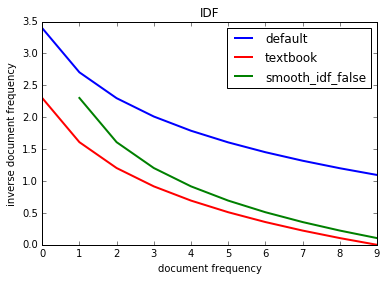

In [60]:
## Plot different IDF options
document_freq = np.arange(0,10,1)
n_d = 10

default = np.log((1 + n_d)/(1 + document_freq)) + 1
textbook = np.log( n_d / (1 + document_freq))
smooth_idf_false = np.log( n_d/document_freq)

plt.figure()
lw = 2
plt.plot(document_freq, default, color='blue',
     lw=lw, label='default')
plt.plot(document_freq, textbook, color='red',
     lw=lw, label='textbook')
plt.plot(document_freq, smooth_idf_false, color='green',
     lw=lw, label='smooth_idf_false')

plt.xlabel('document frequency')
plt.ylabel('inverse document frequency')
plt.title('IDF')
plt.legend(loc="upper right")
plt.show()


In [61]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

In [62]:
#get the bag-of-words from the vectorizer and
#then use TFIDF to weight the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_corpus ) 
test_bag_of_words = vectorizer.transform( test_processed_corpus )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 13.39s


### Activity 2: Words are *Just Too Long*

**20 mins**

In text analysis, words are frequently **stemmed** or **lemmatized** in order to reduce the size of the vocubalary and treat words with similar semantic meaning as the same word. Stemming consists of removing parts of words to create a stem. For example, the word tokens `eat, eating, eatery, eaten, eater` would all be stemmed to the word `eat`. The CountVectorizer provides an easy way incorporate stemming into preprocessing via the *tokenizer* parameter which takes a function handle as an argument. For this activity, create a function to pass to the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) that will stem all words in your corpora. Use the CountVectorizer with this function as an argument to preprocess the corpus (this may take some time). Store the result in a variable called `stemmed_corpus`. Below is an example of a stemmer from the nltk toolkit that will be helpful.  

In [63]:
stemmer = SnowballStemmer("english")
x = 'eating'
stemmer.stem(x)

'eat'

In [64]:
# ANSWER 
def tokenize_and_stem(comment, stemmer = stemmer):
    """
    Takes a reddit comment and stemmer as input
    and returns a list of stemmed words
    
    params: 
        str comment: comment to stem 
        nltk.stemmer stemmer: nltk stemmer object 
        
    rtype: ls[str]
    """
    stemmed_comment = [stemmer.stem(word) for word in comment]
    return stemmed_comment
    
vectorizer_stem = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=tokenize_and_stem, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

start_time = time.time()
train_bag_of_words_stem = vectorizer.fit_transform( train_corpus ) 
test_bag_of_words_stem = vectorizer.transform( test_corpus )
if USE_IDF:
    train_tfidf_stem = transformer.fit_transform(train_bag_of_words)
    test_tfidf_stem = transformer.transform(test_bag_of_words)
features_stem = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 12.03s


In [65]:
#relabel our labels as a 0 or 1
# depression corresponds to a 1 
le = preprocessing.LabelEncoder() 
le.fit(subreddit_id)
subreddit_id_binary = le.transform(subreddit_id)

## Fit and Evaluate a Supervised Model

**Fit** 
We will fit a regularized logistic regression model that takes a comment as input and produces a subreddit classification (/r/SuicideWatch or /r/depression) as output. 

### Regularized Logistic Regression 

Regularized logistic regression solves the following optimization problem:

$$ \min_{\bf w}{\frac{1}{2}||{\bf w}||_d + C \sum_{i=1}^{N}{\textrm{log}(1+e^{−{y_i}{\bf w}^{T}x_i})} }$$

where $(x_i, y_i)$ are the features and label for the $i$th datapoint, $\bf w$ is a vector of model coefficients (or weights), $C$ is a regularization parameter, and $d$ specifies a norm (usually l1 or l2). The l1 norm will force coefficients that are not useful for class dicrimination to zero. The loss function $\textrm{log}(1+e^{−{y_i}{\bf w}^{T}x_i})$ is derived from a probabilistic model and is referred to as the logistic loss.  


In [66]:
# Fit a regularized logistic regression model  
clf = LogisticRegression(penalty='l2')
mdl = clf.fit(train_tfidf, 
              subreddit_id_binary[train_idx])
y_score = mdl.predict_proba( test_tfidf )


### Evaluate
To evalute how our classifer performed we plot the Receiver Operating Characteristic (ROC) curve. The ROC curve is a way of lookin at overall classifier performance. For each test comment, the classifier produces a score indicating how confident the classifier is that the comment was posted in the depression subreddit. In order to produce classifications from these scores, we need to set a threshold above which a score is converted into a positive classificaiton. The ROC curve plots the false positive and true positive rate for every possible threshold we could set. We find the Area Under the Curve (AUC) which ranges from 0.5 (chance) to 1 (perfect prediction). The dashed line plots chance ROC.

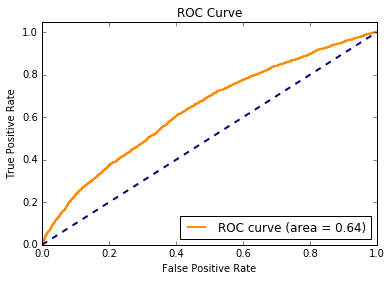

In [67]:
plot_roc(subreddit_id_binary[test_idx], y_score[:,1])

## Feature Importance

### Activity 3: 

**20mins** 

To understand what the model is doing, we want to see which features make the model more likely to classify a comment as a certain class. The CountVectorizer provides a list of features (using the `get_feature_names()` method) and model coefficients can be found in using the `coef_` method. For this activity, make a sorted list or dictionary of features and their importances (i.e., the corresponding coefficient value). Print the 5 most important features for classifying a comment as each of our class labels, SuicideWatch and depression. 

Note, this is pretty easy since we are using Logistic Regression. Feature importance may require more complicated analysis for other methods. 

In [68]:
# ANSWER 
coef = mdl.coef_.ravel()

dict_feature_importances = dict( zip(features, coef) )
orddict_feature_importances = OrderedDict( 
                                sorted(dict_feature_importances.items(), key=lambda x: x[1]) )
                                # lambda is an anonymous function. in this case, we take the first 
                                # element of each item of the dictionary as the key to sort by
        

ls_sorted_features  = list(orddict_feature_importances.keys())

num_features = 5
suicidewatch_features = ls_sorted_features[:5] #SuicideWatch
depression_features = ls_sorted_features[-5:] #depression
print('SuicideWatch: ',suicidewatch_features)
print('depression: ', depression_features[::-1])

SuicideWatch:  ['lg', 'esteem', 'www reddit', 'https www', 'www youtube']
depression:  ['youtube com', 'reddit com', 'depression', 'self esteem', 'productive']


## Examine Confident Predictions 

We want to see which comments the model scores as highly probable to belong to either class. This step can help to look for patterns in model classification and to check for any obvious errors. The predict probability refers to the probablity of a comment belonging to the depression subreddit. Therefore, comments belonging to the SucideWatch subreddit will have a low probablity.



In [69]:
# maybe do something with this crazy indexing: this is python not C!
num_comments = 5
subreddit0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
subreddit1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression

# convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([subreddit0_comment_idx, 
                                               subreddit1_comment_idx])


In [70]:
# these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_subreddit_id[i],
                                          y_score[i,1],
                                          test_corpus[i]))

SuicideWatch:0.00021399175338538608
---
LOL wow...you actually searched that for me. 

Hmmm...I wouldn't know how to start. I would appreciate a nudge in the right direction though! I REALLY would like to do something like that to maybe help people out. My T even said that once I am more stable for a while that I should go do work advocating for people with mental health issues and maybe go around to schools and such to be sort of a motivational speaker and educator about mental illness--all told from the perspective of someone with severe depression, borderline personality disorder, and anorexia. Interesting...I think a blog or even a vlog would be a good start.

&lt;3 I am feeling FANTASTIC right now and I want to share all the love I have in my heart with each person who is still hurting here tonight. I have been in your shoes, and I wouldn't be surprised if I find myself there again (again, just being real), so I understand and I have a lot of compassion and empathy for all of you.

As can be seen from the comments for the three highest probablities for SucideWatch and depression, the classifier does a good job. Note the last entry in the list of SuicideWatch top comments is miscategorized. This is most likely due to references to depression, depression medication, and psychological treatment. 

In [71]:
# clear some memory 
train_corpus = None
test_corpus = None

print_memory() # prints memory usage in Gb

3.111460864


# Comment Similarity and Clustering: Unsupervised Learning

The first step in grouping documents is to define a measure of similarity between documents. A common measure of similarity for non-text data is euclidean distance. However the euclidean distance between document-term vectors ignore the length of the document. For example, if document one consists of a single sentence and document two consists of that same sentence repeated multiple times, the euclidean distance will be nonzero. To overcome this issue documents are often compared using cosine similarity, which measures the angle between two count vectors. 

### Cosine Similarity 

The cosine similarity between two vectors ${\bf x}$ and ${\bf y}$ is defined as: 

$$\textrm{cos}({\bf x},{\bf y}) = \frac{{\bf x} \bullet {\bf y}}{||\bf x|| \; || \bf y ||}$$. 

The common conceptual interpretations of the cosine similarity is the angle between two vectors. In text analysis each document is represented as a point in a $V$-dimensional, where $V$ is the size of the vocabulary. Thus by normalizing we are looking at the percent of a document that each word compromises instead of the raw counts of word tokens. 


Below is an example illustrating why we use cosine distance. The example computes the euclidean and cosine distances between repeated sentences. 

Return to [TOC](#Table-of-Contents)

In [72]:
sentences = ['The girl went to the store', 
             'The girl went to the store. The girl went to the store',
             'The girl went to the store. The girl went to the store. The girl went to the store']

vectorizer_sim = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=(0,1)
                            )

sentence_count = vectorizer_sim.fit_transform( sentences ) 


euclidean_distance = euclidean_distances(sentence_count, Y = None)# sentence_count, Y=None, dense_output=True, 'l2')
cosine_distance = cosine_distances(sentence_count, Y=None )

print("Euclidean Distance\n", euclidean_distance.round(2))
print("\nCosine Distance\n", cosine_distance.round(2))

Euclidean Distance
 [[ 0.    2.83  5.66]
 [ 2.83  0.    2.83]
 [ 5.66  2.83  0.  ]]

Cosine Distance
 [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -0.]]


In [73]:
# define count vectorizer for clustering 
#MIN_DF = 0.001
#MAX_DF = 0.8
vectorizer_clust = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

num_comments = 1000
bag_of_words_clust = vectorizer_clust.fit_transform( processed_corpus[0:(num_comments-1)] ) 
processed_corpus_clust = processed_corpus[0:(num_comments-1)]
corpus_clust = corpus[0:(num_comments-1)]



In [74]:
# #del corpus_clust[396]
# def delete_row_csr(mat, i):
#     """
#     Function to remove a row from a scipy.sparse.csr_matrix. 
#     Taken from 
#     http://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices
    
#     params: 
#         scipy.sparse.csr_matrix mat
#         int i: row to delete 
#     """
#     if not isinstance(mat, scipy.sparse.csr_matrix):
#         raise ValueError("works only for CSR format -- use .tocsr() first")
#     n = mat.indptr[i+1] - mat.indptr[i]
#     if n > 0:
#         mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
#         mat.data = mat.data[:-n]
#         mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
#         mat.indices = mat.indices[:-n]
#     mat.indptr[i:-1] = mat.indptr[i+1:]
#     mat.indptr[i:] -= n
#     mat.indptr = mat.indptr[:-1]
#     mat._shape = (mat._shape[0]-1, mat._shape[1])
    
# corpus_clust = np.delete(corpus_clust, 396)
# processed_corpus_clust = np.delete(corpus_clust, 396)
# delete_row_csr(bag_of_words_clust, 396)

## Agglomerative Clustering 

The idea behind agglomerative clustering is to cluster nearby data points together in a bottom up fashion. Suppose we have $n$ data points $\{x_1, ..., x_N\}$. First, we pre-compute the similarity between all data points using our choice of distance metric (affinity in sci-kit learn). We start with a collection of clusters $C$ that contains $N$ singleton clusters (cluster $c_i = {x_i}$). We repeat the following process until we have $K$ clusters: 

1. Find the closest pair of clusters ( $\min_{i,j} D(c_i, c_j)$ ). $D$ depends on the similarity values between each element of each cluster.     
2. Add a new cluster $c_{i+j}$ to collection $C$ such that $c_{i+j}= c_i \cup c_j$.    
3. Remove clusters $c_i$ and $c_j$ from $C$.    

The distance $D$ is defined between clusters. The following distances are supported in sci-kit learn: 

* The *ward distance* minimizes the variance of the clusters being merged. I.e., it computes the sum of squares error. 
* The *average* distance uses the average of the distances of each observation of the two sets.
* The *complete or maximum* distance uses the maximum distances between all observations of the two sets.


\* Material is from this [tutorial](https://www.youtube.com/watch?v=XJ3194AmH40). 

In [75]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity="cosine", linkage ="average")
cluster.fit(bag_of_words_clust.toarray())
labels = cluster.labels_

label_counter = Counter(labels)

### Activity 4: Cosine Deception 
**20 mins**

Use the code above to find clusters in the data using [Agglomerative Clusting](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). Examine the comments that are assigned to each cluster using the function `examine_comment_labels` defined below. Notice that the comments in Group 0 are all short comments. Wasn't the point of using cosine distance to prevent short comments from being similar?  

See if you can figure out why these comments are being grouped together. What are some ways to fix this error? 

**Hint**: look at the comments after converting them into bags of words. 

In [76]:
def examine_comment_labels(num_comments_to_view, label_counter, corpus_clust, num_comments):
    """
    Function that prints comments and their cluster labels. The function can print
    the raw comments, processed comments, or bag of words. 
    
    params: 
        int num_comments_to_view: the number of comments to view for 
            each group
        Counter label_counter: contains the cluster labels for each item 
            in the dataset
        numpy.ndarray or scipy.sparse.csr.csr_matrix corpus: the corpus 
            processed corpus, or bag of words representation of our data 
        int num_comments: number of comments contained in corpus
    """
    for key, value in label_counter.items():
        count = 0
        print("\n-------Group{}-------\n\n".format(key))
        for i in range(0, num_comments-1):
            if (labels[i] == key) & (count < num_comments_to_view):
                print("Comment {0}: {1}\n".format(i, corpus_clust[i]))
                #print("Comment {0}: {1}\n".format(i, processed_corpus[i]))
                count += 1

                
# examine the comments that fall in each group
# what defines each group?
print(label_counter)
num_comments_to_view = 4
print('prohibition' in stopwords.words('english'))
examine_comment_labels(num_comments_to_view, label_counter, corpus_clust, num_comments-1)




Counter({1: 997, 0: 1, 3: 1})
False

-------Group0-------


Comment 396: Why are you doing this to yourself? 


-------Group1-------


Comment 0: Systems of living have been built around us to make us miserable.  Idk where you are but if you can.  Go shooting.   Trust me on this. Something about shooting guns helps with that feeling.  

Comment 1: Just logged back onto my alt. Thank you. That means a lot to me, I know I'm late and all but ... thanks.

Comment 2: Hey, do you know what it is that makes you feel such hatred towards these things? Does the violence make your thoughts go in an unwanted direction? And when you say these things make them bad people, do you mean you think your friends are bad people for enjoying the shows/games, or that the people who make them are bad? It sounds like it could easily be a depression thing tbh.

Comment 3: Right there with you. National merit scholar now failing classes. Gpa from 3.7 to 2.5. Depression is a bitch. You just have to find what work

In [77]:
# clear memory 
corpus = None
processed_corpus = None
test_processed_corpus = None

# Topic Modeling: Dimensionality Reduction

In this portion of the tutorial we will be extracting topics in the form of commonly co-occuring words from the corpus of data. A topic model is a generative model of document creation used for automatic summarization of text into topics, or mixtures of words. While many variants exist (e.g., supervised, unsupervised, dynamic, hierarchical, structural), this tutorial will cover the standard topic model. The standard topic model makes three assumptions: 

- Bag-of-words: semantic meaning can be extracted from word co-occurance
- Dimensionality reduction is essential to understanding semantic information 
- Topics (lower dimensional units) can be expressed as a probability distribution over words 


<img src="figs/topic_model.png" style="width :85%; height: 85%"/>


Return to [TOC](#Table-of-Contents)

## Topic Model IO

### Input     

Document term count matrix    

### Output 

**Topics**--the probability of each word being expressed in a given topic    
**Document Mixtures**--the probability of each topic being expressed in a document  

<img src="figs/topic_model_io.png" style="width:85%; height:85%"/>


## Example Topics 

<img src="figs/example_topics.png" style="width:85%; height:85%"/>

\* These topics were extracted from a *supervised* topic model. In this case, the topics correspond to each subreddit. 

## Load and Preprocess Reddit Data

In [78]:
start = time.time()
corpus_all, subreddit_id_all = load_reddit('./data/RC_2015-05.json',MIN_CHAR=250)
end = time.time()
print('Loading takes {0:2f}s'.format(end-start))

Loading takes 4.061205s


In [79]:
# parameters for vectorizer 
ANALYZER = "word" # unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode' 
TOKENIZER = None
NGRAM_RANGE = (0,1) # Range for n-grams 
MIN_DF = 10/len(corpus_all) # Exclude words that are contained in less that x percent of documents 
MAX_DF = 0.9  # Exclude words that are contained in more than x percent of documents 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

In [80]:
# Get rid of punctuation and set to lowercase  
start = time.time()
processed_corpus_all = [ re.sub( RE_PREPROCESS, ' ', comment).lower() for comment in corpus_all]

#tokenzie the words
bag_of_words_all = vectorizer.fit_transform( processed_corpus_all ) 
end = time.time() 
#grab the features/vocabulary
features_all = vectorizer.get_feature_names()
print("Processing took {}s".format(end - start))

Processing took 21.793128967285156s


In [81]:
print("{} words in vocabulary\n".format(len(features_all)))

# print subreddits and number of topics 
print(Counter(subreddit_id_all))
print(len(subreddit_id_all))

13832 words in vocabulary

Counter({'depression': 12079, 'offmychest': 10661, 'stopdrinking': 6958, 'SuicideWatch': 6098, 'ADHD': 5674, 'GetMotivated': 4799, 'Anxiety': 4466, 'Meditation': 3608, 'stopsmoking': 1867, 'leaves': 1629, 'BPD': 1618, 'BipolarReddit': 1515, 'OpiatesRecovery': 1391, 'socialanxiety': 1221, 'StopGaming': 946, 'schizophrenia': 898, 'mentalhealth': 572, 'ptsd': 566, 'MMFB': 483, 'alcoholism': 378, 'rapecounseling': 283, 'BipolarSOs': 272, 'AlAnon': 267, 'ZenHabits': 237, 'alcoholicsanonymous': 219, 'getting_over_it': 208, 'EatingDisorders': 203, 'Anger': 165, 'selfhelp': 150, 'StopSelfHarm': 136, 'dpdr': 105, 'survivorsofabuse': 96, 'helpmecope': 45, 'AtheistTwelveSteppers': 29, 'problemgambling': 17, 'buddhistrecovery': 12, 'MaladaptiveDreaming': 9, 'PanicAttack': 8, 'psychoticreddit': 8, 'secularsobriety': 6, 'SMARTRecovery': 5, 'secondary_survivors': 5, 'hardshipmates': 4, 'PanicParty': 4, 'afterthesilence': 3, 'feelgood': 2, 'Existential_crisis': 1, 'jessiespa

## Fit a Topic Model

To create our topics we will use Latent Dirichlet Allocation (LDA, i.e., the standard topic model). Both [scikit learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) and [gensim](https://radimrehurek.com/gensim/) provide software for fitting LDA. Both modules use [online variational inference](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf) to fit the model, but methods such as [Gibbs sampling](https://people.cs.umass.edu/~wallach/courses/s11/cmpsci791ss/readings/steyvers06probabilistic.pdf) are also popular. 

In [82]:
# Options
N_TOPICS = 50
N_TOP_WORDS = 10

start = time.time()
lda = LatentDirichletAllocation( n_topics = N_TOPICS )
#lda.fit(bag_of_words_all)
doctopic = lda.fit_transform(bag_of_words_all)
end = time.time() 
print("Processing took {}s".format(end- start)) # ~255s for ~1000 features, , ~475 for 13000

print("Shape of document topic matrix: {}".format(doctopic.shape))
print("Shape of topic word matrix: {}".format(lda.components_.shape))

Processing took 442.95932483673096s
Shape of document topic matrix: (69927, 50)
Shape of topic word matrix: (50, 13832)


## Display the top ten words for each topics 

Qualitatively examining the topic output is the most common method for assessing fit of a topic model. Ideally, most topics will be interpretable. Topic interpretability tends to increase with the number of documents used during fitting. Since this topic model is unsupervised, topic names (in this case integers $1,...,T$) are arbitrary. 

In [83]:
ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
    keywords = ', '.join( features_all[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)
    

0 meditation, mind, practice, body, eat, breath, mindfulness, breathing, gym, dog
1 mental, health, book, treatment, kill, interested, hospital, state, called, coffee
2 quite, must, news, movie, patterns, role, chemical, hello, ice, email
3 stay, control, hate, get, worry, goes, easier, heart, husband, definitely
4 meds, system, response, expect, information, insurance, memory, throw, handle, usually
5 job, work, working, success, top, position, company, business, useful, career
6 day, time, days, get, week, first, one, like, months, much
7 years, life, never, got, back, still, let, went, home, guess
8 answer, question, asking, kid, putting, research, doubt, terms, clear, bring
9 money, using, jobs, higher, eye, spending, doc, attitude, hobby, picture
10 wonder, opposite, strange, faith, occasionally, complicated, insight, hardly, master, agreed
11 friends, relationship, friend, love, reading, girl, true, words, meet, person
12 honestly, yet, lose, sex, weight, knows, healthy, ex, trus

## Most Prevalent Topic in Each Comment

We will examine some of the comments and list which topic comprises the largest portion of the document. 

In [84]:
p = 95 # percentile of words to highlight 
num_comments = 5
for comment_id in range(num_comments):
    
    # get most prevalent topic 
    topic_id = np.argsort(doctopic[comment_id])[N_TOPICS-1]
    
    # find most prevalent words in the most prevalent topic
    topic = lda.components_[topic_id]
    feat_idx = np.argsort(topic)[::-1]
    num_words = (topic > np.percentile(topic, p)).sum()
    feat_idx = feat_idx[0:num_words]
    top_features = [features_all[i] for i in feat_idx]
    
    # create highlighted version of the comment 
    comment_color = []
    comment = corpus_all[comment_id].split()
    
    for word in comment: 
        if re.sub(RE_PREPROCESS, '', word).lower() in top_features:
            comment_color.append('\x1b[31m' + word + '\x1b[0m') # makes the word print in red 
        else:
            comment_color.append(word)
    
    print('comment_id:',
          comment_id,
          subreddit_id_all[comment_id],
          'topic_id:',
          topic_id,
          '\nkeywords:',
           ls_keywords[topic_id])
    print('---')
    print(' '.join(comment_color))
    print('===')

comment_id: 0 offmychest topic_id: 44 
keywords: like, people, know, think, feel, get, things, want, really, something
---
It's not your fault don't think that. Hey if this helps it does then if it doesn't well. At least I can talk about it. I shot my dog. I had him for 10 years. I can home from partying and it was New Years so I was going to shoot off my .40 so... Well I was loading it outside and I shot it off accidentally. Right into my dog. Me having about 5-7 tequila shots into me though if I go to sleep I would wake up and he would be okay. Well if I called a vet when I shot him I could have saved him. Or at least from his pain. So I woke up saw a dead dog in my yard… i cried for hours. That old dog still had a few good years in him. That was my fault and you sitting on a little tiny mouse is more understandable than a man discharging a firearm into a shitzu. Don't feel to bad.
===
comment_id: 1 offmychest topic_id: 11 
keywords: friends, relationship, friend, love, reading, girl

## Comment with Largest Proportion of Each Topic

We will iterate through topics and find the comment that most expresses that topic.  

In [85]:
p = 95 # percentile of words to highlight 
topics_to_view = [6, 25, 28, 41] 
for topic_id in topics_to_view:
    
    # find the comment that most expresses that topic
    comment_id = doctopic[:,topic_id].argmax()
    
    # find most prevalent words in the most prevalent topic
    topic = lda.components_[topic_id]
    feat_idx = np.argsort(topic)[::-1]
    num_words = (topic > np.percentile(topic, p)).sum()
    feat_idx = feat_idx[0:num_words]
    top_features = [features_all[i] for i in feat_idx]
    
    # create highlighted version of the comment 
    comment_color = []
    comment = corpus_all[comment_id].split()
    
    for word in comment: 
        if re.sub(RE_PREPROCESS, '', word).lower() in top_features:
            comment_color.append('\x1b[31m' + word + '\x1b[0m') # makes the word print in red 
        else:
            comment_color.append(word)
    
    print('comment_id:',
          comment_id,
          subreddit_id_all[comment_id],
          'topic_id:',
          topic_id,
          '\nkeywords:',
           ls_keywords[topic_id])
    print('---')
    print(' '.join(comment_color))
    print('===')

comment_id: 53965 stopsmoking topic_id: 6 
keywords: day, time, days, get, week, first, one, like, months, much
---
I have been smoking a pack a day since my early 20s. I'm 45 now. I quit 309 days ago, and I will never touch another cigarette again. It's been the best decision in my life. This sub did it for me. The short version: you're addicted to nicotine, the addiction is real, junkie-you will tell yourself anything to get back to smoking, don't do it. It may seem difficult now, but you basically have a nicotine hangover. It will go away if you don't smoke (stay sober). It's worth it, smoking is silly, you don't need nicotine. The long version: Here are my thoughts on quitting, rehashed from a post I made when I was 30 days in. I know there are other thoughts, but these are mine. **How / when to quit:** * Quitting is easy, just stop smoking. Getting the nicotine out of your body only takes three days. * Cold turkey is the best way to quit. Gum, patches, ecigs, just prolong the suff

## Cool Visualizations 
    
<img src="figs/supreme_court_topics.jpg"/> 

[Mental Health Subreddit Topics](http://geebioso.github.io/Subreddit-Topic-Visualization/)

Return to [TOC](#Table-of-Contents)


In [86]:
print_memory() # prints memory usage in Gb 

1.89865984
